# 1. Exploration

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
# source = "/content/gdrive/My Drive/Colab Notebooks/fer2013/fer2013.csv" 
source = 'fer2013/fer2013.csv'
data = pd.read_csv(source)
# data.head()
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

<AxesSubplot:>

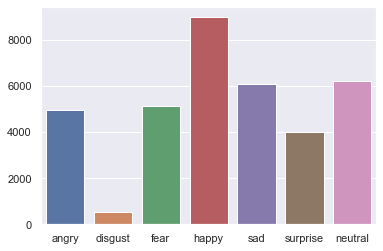

In [3]:
# categorical labels: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
clases = {
    0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'sad',
    5:'surprise',
    6:'neutral',
}

# data['emotion'].value_counts()
dict_clases ={
    clases[0]: data['emotion'].value_counts()[0],
    clases[1]: data['emotion'].value_counts()[1],
    clases[2]: data['emotion'].value_counts()[2],
    clases[3]: data['emotion'].value_counts()[3],
    clases[4]: data['emotion'].value_counts()[4],
    clases[5]: data['emotion'].value_counts()[5],
    clases[6]: data['emotion'].value_counts()[6],
}

keys = list(dict_clases.keys())
vals = [dict_clases[k] for k in keys] # get values in the same order as keys
sns.barplot(x=keys, y=vals)

In [4]:
rows = data.shape[0]
columns = data.shape[1]
print(f'Hay {rows} filas y {columns} columnas')

Hay 35887 filas y 3 columnas


In [5]:
# from google.colab.patches import cv2_imshow

sample_imgs = []
sample_class = []

for i in range(1,10):
    id = np.random.randint(1,rows)
    
    line = data['pixels'][id] # image id
    clase = data['emotion'][id]  # image class
    
    image_data = np.asarray([int(x) for x in line.split()])  # numpy array
    img = image_data.reshape((48,48)).astype('uint8')*255  # 2-d numpy array
    img = cv2.bitwise_not(img)  # w&b bitwise inverted or do not multiply by 255
    
    # print(f'ID:{id} \n{clases[clase]}')
    # cv2_imshow(img)  # patch for colabs instead of cv2.imshow
    sample_imgs.append(cv2.flip(img, 0))
    sample_class.append(clases[clase])

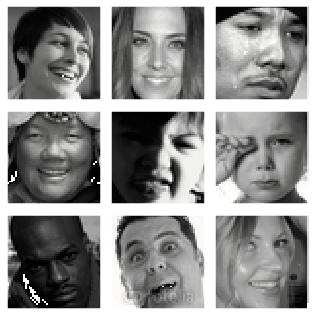

In [6]:
# !pip install seaborn-image
import seaborn_image as isns
g = isns.ImageGrid(sample_imgs, 
                   col_wrap=3, 
                   height=1.5, 
                   cmap="gray", 
                   cbar_label=sample_class, 
                   cbar=False, 
                   orientation='h')

# 2. Training

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

def get_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_gpus())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

['/device:GPU:0']
2.5.0
Num GPUs Available:  1


In [2]:
# training

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random
import seaborn as sns
import cv2
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Activation, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sns.set_theme(style="dark")

In [3]:
# Training  28709
# Test      7178 (public+private)
source = 'fer2013/fer2013.csv'
data = pd.read_csv(source)
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [4]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [5]:
# groups
# Angry, disgust, fear, sad = Upset = 0, 1, 2, 4 = 0
# Happy = Happy = 3 = 1
# Surprise = surprise = 5 = 2
# Neutral = Neutral = 6 = 3

clases_original = {
    0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'sad',
    5:'surprise',
    6:'neutral',
}

clases_new = {
    0:'upset',
    1:'happy',
    2:'neutral',
}

data["emotion"].replace({1:0, 2:0, 4:0}, inplace=True)  # to upset
data["emotion"].replace({3:1}, inplace=True)  # to happy
data["emotion"].replace({6:2, 5:2}, inplace=True)  # to neutral

In [6]:
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,0,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,2,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,0,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,0,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,1,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,1,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,0,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [7]:
print(data['emotion'].unique())
print(data.shape)

[0 2 1]
(35887, 3)


**adding extra dataframe**

In [8]:
source2 = 'fer2013/fer2021.csv'
data2 = pd.read_csv(source2)
data2.head(10)

,emotion,pixels,Usage
0,1,10 10 10 10 10 10 10 10 10 11 14 18 22 24 20 2...,Training
1,1,109 41 28 29 30 30 30 30 31 33 40 52 68 83 94 ...,Training
2,1,61 54 50 47 45 46 50 68 88 103 113 121 127 128...,Training
3,1,33 33 33 33 31 30 31 32 33 37 39 38 38 37 38 3...,Training
4,1,16 17 19 24 25 29 29 39 32 27 31 39 47 63 81 1...,Training
5,1,105 73 75 110 129 146 150 142 133 121 114 115 ...,Training
6,0,24 16 20 25 22 16 17 23 30 35 34 39 42 51 57 7...,Training
7,2,58 50 46 47 46 45 52 72 91 106 118 124 128 128...,Training
8,2,10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 1...,Training
9,2,115 117 90 110 118 126 132 133 134 131 125 117...,Training


In [9]:
source3 = 'fer2013/fer2021_2.csv'
data3 = pd.read_csv(source3)
data3.head(10)

,emotion,pixels,Usage
0,2,78 80 73 77 97 130 133 115 94 85 105 79 86 85 ...,Training
1,1,61 55 64 131 136 167 147 125 98 73 53 92 126 1...,Training
2,1,54 48 47 54 54 48 53 67 80 93 106 115 128 137 ...,Training
3,2,80 52 49 52 58 86 122 143 150 154 154 154 158 ...,PublicTest
4,1,43 47 46 50 52 60 65 79 97 103 110 114 122 136...,Training
5,1,43 50 43 39 44 51 56 60 72 74 90 109 132 144 1...,Training
6,1,40 74 86 109 125 149 166 173 180 186 189 191 1...,PublicTest
7,1,54 75 120 132 128 126 121 123 125 125 126 128 ...,Training
8,1,52 76 104 124 141 151 157 169 175 180 183 185 ...,Training
9,1,67 57 44 67 83 109 141 155 163 165 163 164 167...,PublicTest


In [10]:
frame = [data, data2, data3]  # data2
dataFinal = pd.concat(frame)
dataFinal.shape

(35982, 3)

<AxesSubplot:>

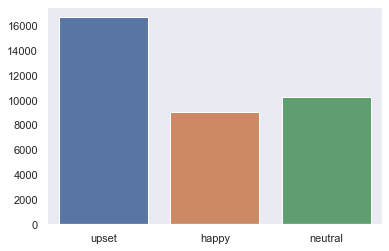

In [11]:
dict_clases_new ={
    clases_new[0]: dataFinal['emotion'].value_counts()[0],
    clases_new[1]: dataFinal['emotion'].value_counts()[1],
    clases_new[2]: dataFinal['emotion'].value_counts()[2],
}

Newkeys = list(dict_clases_new.keys())
Newvals = [dict_clases_new[k] for k in Newkeys] # get values in the same order as keys
sns.barplot(x=Newkeys, y=Newvals)

In [12]:
dataFinal['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [13]:
NumClasses = len(dict_clases_new)
NumClasses

3

In [28]:
# splitting the dataset

KerasSplit = False
train_data = []
train_label =[]
test_data = []
test_label = []
private_data = []
private_label = []

total_train = dataFinal.shape[0]
pbar = tqdm(total=total_train, desc='Loading training images')
for index, row in dataFinal.iterrows():
    
    image_bw = np.asarray([int(x) for x in row['pixels'].split()])
    image_bw = image_bw.reshape(48, 48).astype('uint8')/255  # /255 normalized
    # image_bw = cv2.flip(image_bw, 0)
    
    if KerasSplit:
        train_data.append(image_bw)
        train_label.append(row['emotion'])
    else:
        if row['Usage'] == 'Training':
            train_data.append(image_bw)
            train_label.append(row['emotion'])
        elif row['Usage'] == 'PublicTest':
            test_data.append(image_bw)
            test_label.append(row['emotion'])
        else:
            private_data.append(image_bw)
            private_label.append(row['emotion'])
    pbar.update(1)
pbar.close()

train_data = np.array(np.expand_dims(train_data, -1))   
train_label = np.array(to_categorical(train_label, num_classes = NumClasses))
test_data = np.array(np.expand_dims(test_data, -1))
test_label = np.array(to_categorical(test_label, num_classes = NumClasses))
private_data = np.array(np.expand_dims(private_data, -1))   
private_label = np.array(to_categorical(private_label, num_classes = NumClasses))
print(f'[info training] \n training data: {len(train_data)} \n training labels: {len(train_label)}')
print(f'[public test] \n test data: {len(test_data)} \n test labels: {len(test_label)}')
print(f'[private test] \n private data: {len(private_data)} \n private labels: {len(private_label)}')

Loading training images: 100%|█████████████████████████████████████████████████| 35982/35982 [00:19<00:00, 1832.63it/s]


[info training] 
 training data: 28789 
 training labels: 28789
[public test] 
 test data: 3604 
 test labels: 3604
[private test] 
 private data: 3589 
 private labels: 3589


[1. 0. 0.]


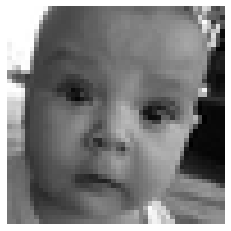

In [29]:
id_random = random.randint(0, len(train_data))
print(train_label[id_random])
plt.imshow(train_data[id_random], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

In [30]:
UniClass = len(dataFinal['emotion'].unique())
weighted = {
        0: round((1 / dataFinal['emotion'].value_counts()[0]) * (dataFinal.shape[0] / UniClass), 3),
        1: round((1 / dataFinal['emotion'].value_counts()[1]) * (dataFinal.shape[0] / UniClass), 3),
        2: round((1 / dataFinal['emotion'].value_counts()[2]) * (dataFinal.shape[0] / UniClass), 3),
}
print( dataFinal.shape[0], UniClass)
weighted

35982 3


{0: 0.718, 1: 1.329, 2: 1.17}

In [31]:
print(f'imágenes para entrenamiento: {len(train_data)} \nimágenes para validación: {len(test_data)}')

imágenes para entrenamiento: 28789 
imágenes para validación: 3604


**Hyperparameters**

In [72]:
epochs = 87  #66 for jup07 without weighted
batch_size = 64  # 64 for jup07 without weighted
learning_rate = 0.001  # (SGD=1E-2, Adam=1E-3)
lr_factor = 0.3  # 0.9 - learning rate factor in plateau
lr_patience = 5  # 6 - learning rate factor in plateau
lr_min = 0.0001 # - min learning in plateau
validation = 0.25 # validation split
SGD = False
jup = 'jup13'

In [73]:
data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(48, 48, 1)),
        layers.experimental.preprocessing.RandomContrast(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ], name='data_augmentation')

model = Sequential(name='moodyNet')

model.add(data_augmentation)
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1))) # kernel_regularizer=l2(0.01)
model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NumClasses, activation='softmax'))

if SGD:
    optimType = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
else:
    optimType = optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimType, loss='categorical_crossentropy', metrics=['accuracy'])
    
model.summary()

Model: "moodyNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 44, 44, 64)        1664      
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 44, 44, 64)        102464    
_________________________________________________________________
batch_normalization_55 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 22, 22, 128)       73856     
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 22, 22, 128)       147

In [74]:
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=lr_factor, patience=lr_patience, min_lr=lr_min)  # jup11 val_loss
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('models/'+jup+'/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

tf.random.set_seed(15896)

history = model.fit(train_data,
          train_label,
          batch_size=batch_size,
          epochs=epochs, 
          callbacks=[lr_reducer, checkpointer, early_stopper], 
          # validation_split=validation,
          validation_data=(test_data, test_label),
          shuffle=True,
          # class_weight=weighted,
          verbose=1
         )

Epoch 1/87
450/450 [==============================] - 11s 23ms/step - loss: 1.1265 - accuracy: 0.4637 - val_loss: 0.9663 - val_accuracy: 0.5391

Epoch 00001: val_loss improved from inf to 0.96627, saving model to models/jup13\weights.hd5
INFO:tensorflow:Assets written to: models/jup13\weights.hd5\assets
Epoch 2/87
450/450 [==============================] - 10s 23ms/step - loss: 0.9467 - accuracy: 0.5408 - val_loss: 1.0421 - val_accuracy: 0.4831

Epoch 00002: val_loss did not improve from 0.96627
Epoch 3/87
450/450 [==============================] - 10s 23ms/step - loss: 0.8709 - accuracy: 0.5931 - val_loss: 0.9541 - val_accuracy: 0.5103

Epoch 00003: val_loss improved from 0.96627 to 0.95407, saving model to models/jup13\weights.hd5
INFO:tensorflow:Assets written to: models/jup13\weights.hd5\assets
Epoch 4/87
450/450 [==============================] - 10s 23ms/step - loss: 0.8154 - accuracy: 0.6288 - val_loss: 0.7719 - val_accuracy: 0.6529

Epoch 00004: val_loss improved from 0.95407 t

450/450 [==============================] - 10s 23ms/step - loss: 0.2787 - accuracy: 0.8894 - val_loss: 0.7475 - val_accuracy: 0.7630

Epoch 00037: val_loss did not improve from 0.58220
Epoch 38/87
450/450 [==============================] - 10s 23ms/step - loss: 0.2490 - accuracy: 0.8994 - val_loss: 0.7311 - val_accuracy: 0.7814

Epoch 00038: val_loss did not improve from 0.58220
Epoch 39/87
450/450 [==============================] - 10s 23ms/step - loss: 0.2414 - accuracy: 0.9047 - val_loss: 0.7441 - val_accuracy: 0.7814

Epoch 00039: val_loss did not improve from 0.58220
Epoch 40/87
450/450 [==============================] - 10s 23ms/step - loss: 0.2286 - accuracy: 0.9091 - val_loss: 0.7676 - val_accuracy: 0.7805

Epoch 00040: val_loss did not improve from 0.58220
Epoch 41/87
450/450 [==============================] - 11s 23ms/step - loss: 0.2251 - accuracy: 0.9106 - val_loss: 0.7735 - val_accuracy: 0.7822

Epoch 00041: val_loss did not improve from 0.58220
Epoch 42/87
450/450 [======

In [75]:
model_json = model.to_json()

with open('models/'+jup+'/model.json', "w") as json_file:
    json_file.write(model_json)

model.save_weights('models/'+jup+'/model.h5')
print("Saved model to disk")

Saved model to disk


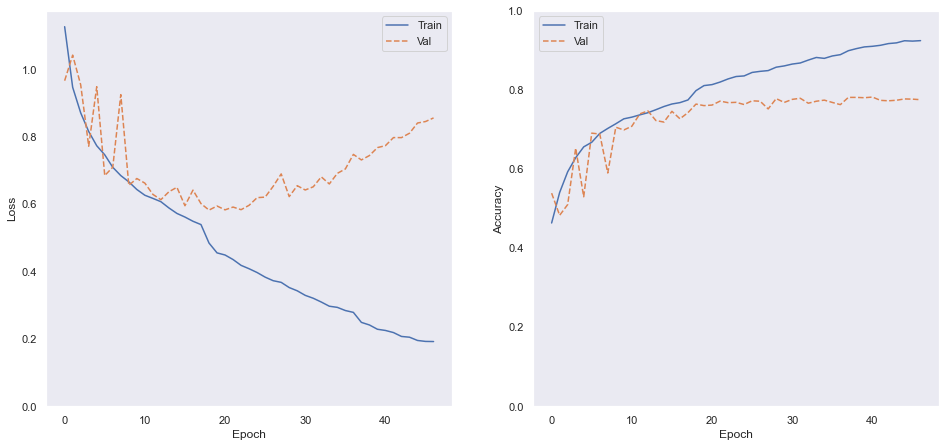

In [79]:
metrics = ['loss', 'accuracy']  # , 'precision', 'recall'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(16, 16))
for n, metric in enumerate(metrics):
    name = metric.replace("_", " ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')  # color=colors[0]
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')  # color=colors[0]
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()
plt.savefig('models/'+jup+'/'+jup+'_metrics.jpg', bbox_inches='tight')
# plt.show()

In [78]:
# predictions for the private dataset

private_predicted = np.argmax(model.predict(private_data), axis=1)  # otherwise still in one-hot-encode
private_labels = np.argmax(private_label, axis=1)

final_score = round(accuracy_score(private_labels, private_predicted), 4)
print (f'Accuracy score = {100*final_score}%')

Accuracy score = 79.77%
